In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as reader
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

return_dataframe = pd.read_pickle('Data/hml_df.pkl')
ls_ret = pd.DataFrame(return_dataframe['hml_return'])
momentum = pd.read_csv("Data/F-F_Momentum_Factor.csv", index_col='Date')

In [28]:
ls_ret

,hml_return
date,
1962-07-31,-0.008225
1962-08-31,0.011839
1962-09-30,0.018033
1962-10-31,0.008743
1962-11-30,-0.017226
...,...
2018-02-28,-0.008893
2018-03-31,0.006576
2018-04-30,0.012575


In [29]:
end_date = dt.date(2018, 6, 30)
start_date = dt.date(1961, 6, 30)
returns = pd.DataFrame(ls_ret)
returns.index = returns.index.rename("Date")
returns

,hml_return
Date,
1962-07-31,-0.008225
1962-08-31,0.011839
1962-09-30,0.018033
1962-10-31,0.008743
1962-11-30,-0.017226
...,...
2018-02-28,-0.008893
2018-03-31,0.006576
2018-04-30,0.012575


In [30]:
momentum.index = pd.to_datetime(momentum.index.astype(str), format='%Y%m')
momentum.index = momentum.index.to_period('M')
momentum.tail()

,Mom
Date,
2024-12,-0.30
2025-01,0.95
2025-02,-0.82
2025-03,-2.82
2025-04,4.94


In [31]:
factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]
factors = factors[1:]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1961-07,2.83,-1.94,-0.08,0.18
1961-08,2.57,-1.71,-0.30,0.14
1961-09,-2.15,-1.07,-0.61,0.17
1961-10,2.58,-1.61,0.18,0.19
1961-11,4.45,1.26,-1.22,0.15


In [32]:
returns.index = pd.to_datetime(returns.index)
returns.index = returns.index.to_period('M')

In [34]:
df = pd.merge(returns, factors, on="Date")
df = pd.merge(df, momentum, on="Date")
df[["Mkt-RF", "SMB", "HML", "RF", 'Mom']] = df[["Mkt-RF", "SMB", "HML", "RF", 'Mom']]/100
df["LS-RF"] = df['hml_return'] - df.RF
RF = factors['RF']
pd.to_pickle(RF, "RF.pkl")
df = df[:(len(df)-1)]
df

,hml_return,Mkt-RF,SMB,HML,RF,Mom,LS-RF
Date,,,,,,,
1962-07,-0.008225,0.0627,0.0152,-0.0337,0.0027,0.0051,-0.010925
1962-08,0.011839,0.0213,0.0122,-0.0112,0.0023,-0.0057,0.009539
1962-09,0.018033,-0.0522,-0.0240,0.0133,0.0021,0.0396,0.015933
1962-10,0.008743,-0.0005,-0.0395,0.0130,0.0026,0.0079,0.006143
1962-11,-0.017226,0.1089,0.0250,0.0085,0.0020,-0.0719,-0.019226
...,...,...,...,...,...,...,...
2018-01,-0.018542,0.0559,-0.0316,-0.0132,0.0011,0.0407,-0.019642
2018-02,-0.008893,-0.0364,0.0027,-0.0110,0.0011,0.0361,-0.009993
2018-03,0.006576,-0.0235,0.0405,-0.0021,0.0012,-0.0124,0.005376


In [35]:
#Fama-French 3 Factor Model
Y = df["LS-RF"]
X = df[["Mkt-RF", 'SMB', 'HML']]
X_sm = sm.add_constant(X)

ols_model = sm.OLS(Y, X).fit(cov_type="HC3")
ols_residuals = ols_model.resid

resid_sq = ols_residuals ** 2 #Squared residuals
var_model = sm.OLS(resid_sq, X).fit(cov_type="HC3") #estimating the residuals
sigma2_hat = var_model.fittedvalues.clip(lower=1e-8) #avoiding 0

sigma = np.diag(sigma2_hat) #constructing Covariance Matrix


model = sm.GLS(Y, X_sm, sigma=sigma)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
residuals = results.resid

print(results.summary())
from statsmodels.iolib.summary2 import summary_col

# Use summary_col to combine models or present a single model
latex_summary = summary_col([results], stars=True, float_format="%.4f").as_latex()
print(latex_summary)


                            GLS Regression Results                            
Dep. Variable:                  LS-RF   R-squared:                       0.627
Model:                            GLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     86.82
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           1.96e-47
Time:                        20:43:44   Log-Likelihood:                 617.22
No. Observations:                 671   AIC:                            -1226.
Df Residuals:                     667   BIC:                            -1208.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.793      0.4

In [36]:
#Random Forest Regression - FFC

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import shap

X = df[["Mkt-RF", 'SMB', 'HML', 'Mom']]
Y = df['LS-RF']

X, Y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
print(regr.score(X, Y))

feature_names = ['Mkt-RF', 'SMB', 'HML', 'Mom']
importances = pd.Series(regr.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("\nFeature Importances:")
print(importances)

# Plot
#importances.plot(kind='barh', title='Feature Importances')
#plt.gca().invert_yaxis()
#plt.show()



explainer = shap.Explainer(regr, X)
shap_values = explainer(X)

# Summary plot of global feature effects
#shap.summary_plot(shap_values, X)

0.8435830500065528

Feature Importances:
SMB       0.814739
Mkt-RF    0.181470
Mom       0.002338
HML       0.001453
dtype: float64


In [37]:
#FFC RF

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Example: X = features (factors), Y = target (LS-RF excess return)
X = df[["Mkt-RF", "SMB", "HML", 'Mom']]  # your features
X = sm.add_constant(X)
Y = df["LS-RF"]

# Fit Random Forest
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X, Y)

# Predictions
Y_pred = regr.predict(X)

# Feature importances (normalized to sum to 1)
importances = regr.feature_importances_
importances_series = pd.Series(importances, index=X.columns)

# Compute pseudo-betas
pseudo_betas = {}
for feature in X.columns:
    # Avoid divide-by-zero by adding a small epsilon
    ratio = Y_pred / (X[feature] + 1e-8)
    elasticity = ratio * importances_series[feature]
    pseudo_betas[feature] = np.median(elasticity)  # or .median()

# Create readable result
pseudo_betas_df = pd.Series(pseudo_betas, name="Pseudo-Beta")
print(pseudo_betas_df)
print(regr.score(X, Y))


const     0.000000
Mkt-RF   -0.023063
SMB      -0.040111
HML       0.367416
Mom       0.007782
Name: Pseudo-Beta, dtype: float64
0.9422870019428309


In [198]:
#Latex export of R-Output

import pandas as pd

def gls_summary_to_latex(results, dep_var="LS-RF", title="Fama-French 3-Factor Model: GLS Regression Results"):
    ci = results.conf_int()
    df = pd.DataFrame({
        'coef': results.params,
        'std err': results.bse,
        'z': results.tvalues,
        'P>|z|': results.pvalues,
        'CI lower': ci[0],
        'CI upper': ci[1],
    })

    model_name = 'General Least Squares'

    latex = []

    # Header
    latex.append(r"\begin{table}[htbp]")
    latex.append(r"\centering")
    latex.append(r"\caption{GLS Regression Results}")
    latex.append(r"\begin{tabular}{lcl}")
    latex.append(r"\toprule")
    latex.append(f"\\textbf{{Dep. Variable:}} & {dep_var} & \\\\")
    latex.append(f"\\textbf{{Model:}} & {model_name} & \\\\")
    latex.append(f"\\textbf{{Method:}} & Least Squares & \\\\")
    latex.append(f"\\textbf{{Date:}} & {pd.Timestamp.today().strftime('%a, %d %b %Y')} & \\\\")
    latex.append(f"\\textbf{{No. Observations:}} & {int(results.nobs)} & \\\\")
    latex.append(f"\\textbf{{Df Residuals:}} & {int(results.df_resid)} & \\\\")
    latex.append(f"\\textbf{{Df Model:}} & {int(results.df_model)} & \\\\")
    latex.append(f"\\textbf{{Covariance Type:}} & {results.cov_type} & \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\vspace{0.5em}")



    latex.append(r"\centering")
    latex.append(f"\\caption{{{title}}}")
    latex.append(r"\label{tab:gls_results}")
    latex.append(r"\begin{tabular}{lrrrrrr}")
    latex.append(r"\toprule")
    latex.append(" & Coef. & Std. Err. & z & P$>|z|$ & [0.025 & 0.975] \\\\")
    latex.append(r"\midrule")

    for idx, row in df.iterrows():
        latex.append(f"{idx} & {row['coef']:.4f} & {row['std err']:.4f} & {row['z']:.4f} & {row['P>|z|']:.4f} & {row['CI lower']:.4f} & {row['CI upper']:.4f} \\\\")

    latex.append(r"\midrule")
    latex.append(f"R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared:.3f}}} \\\\")
    latex.append(f"Adj. R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared_adj:.3f}}} \\\\")
    latex.append(f"F-statistic & \\multicolumn{{6}}{{r}}{{{results.fvalue:.2f}}} \\\\")
    latex.append(f"Prob (F-statistic) & \\multicolumn{{6}}{{r}}{{{results.f_pvalue:.2e}}} \\\\")
    latex.append(f"Log-Likelihood & \\multicolumn{{6}}{{r}}{{{results.llf:.2f}}} \\\\")
    latex.append(f"AIC & \\multicolumn{{6}}{{r}}{{{results.aic:.1f}}} \\\\")
    latex.append(f"BIC & \\multicolumn{{6}}{{r}}{{{results.bic:.1f}}} \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")

    return "\n".join(latex)
latex_code = gls_summary_to_latex(results)
with open("gls_results.tex", "w") as f:
    f.write(latex_code)

Text(0.5, 1.0, 'PACF')

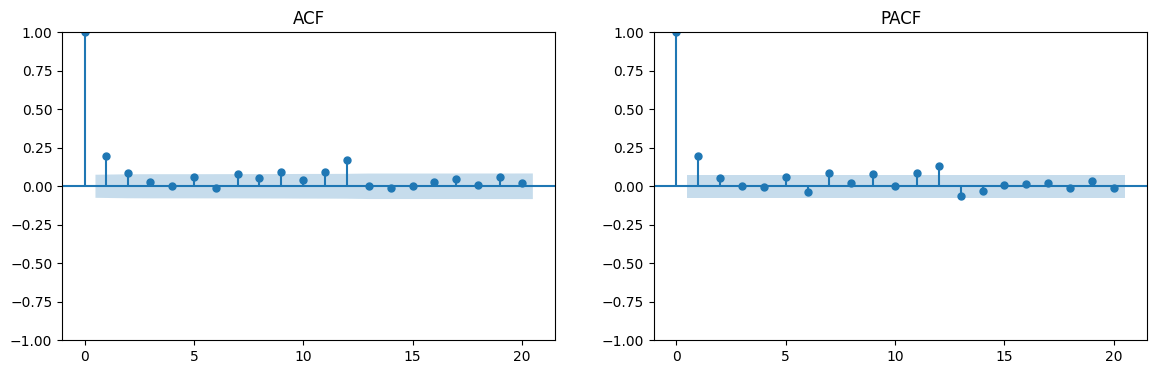

In [284]:
#ACF, PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(residuals, lags=20, ax=axes[1], method="ywm")
axes[1].set_title("PACF")

In [38]:

returns.rename(columns={'hml_return': 'LSR'}, inplace=True)
returns


,LSR
Date,
1962-07,-0.008225
1962-08,0.011839
1962-09,0.018033
1962-10,0.008743
1962-11,-0.017226
...,...
2018-02,-0.008893
2018-03,0.006576
2018-04,0.012575


Values do not match the theory. New approach by using North-America Data from Kenneth R. French

In [39]:
#Preparation of Data for usage
factors_us = pd.read_csv("Data/North_America_3_Factors.csv", index_col="Date")
momentum_us = pd.read_csv('Data/North_America_MOM_Factor.csv', index_col='Date')
momentum_us.index = pd.to_datetime(momentum_us.index.astype(str), format='%Y%m')
momentum_us.index = momentum_us.index.to_period('M')
factors_us.index = pd.to_datetime(factors_us.index.astype(str), format='%Y%m')
factors_us.index = factors_us.index.to_period('M')
momentum.tail()
factors_us = factors_us/100
momentum_us = momentum_us/100

#returns_df = pd.DataFrame(returns)
#returns_df = returns_df.dropna()
#returns_df = returns_df.to_period('M')

hml_ret = pd.read_pickle('Data/hml_ret.pkl')
hml_ret = pd.DataFrame(hml_ret)
hml_ret.index.rename('Date', inplace=True)
hml_ret.index = hml_ret.index.to_period('M')
hml_ret
"""change_in_aggragate_valuation = pd.read_pickle('Data/change_in_aggregate_valuation.pkl')
change_in_aggragate_valuation.index = change_in_aggragate_valuation.index.to_period('M')
change_in_aggragate_valuation.rename(columns={'avg_value':'Change in aggregate valuation'}, inplace=True)
income_yield = pd.read_pickle('Data/income_yield.pkl')
income_yield.index = income_yield.index.to_period('M')
income_yield.rename(columns={'avg_value':'Income Yield'}, inplace=True)
migration = pd.read_pickle('Data/migration.pkl')
migration.index = migration.index.to_period('M')
migration.rename(columns={'avg_value':'Migration'}, inplace=True)"""

#decomposition = [change_in_aggragate_valuation, income_yield, migration]

df_us = pd.merge(factors_us, momentum_us, on="Date")
df_us = pd.merge(df_us, hml_ret, on="Date")
#df_us = pd.concat([df_us, change_in_aggragate_valuation, income_yield, migration], axis=1, join='inner')
df_us["LS-RF"] = df_us.hml_return- df_us.RF
#RF = factors['RF']
pd.to_pickle(df_us, "df_us.pkl")

df_us.rename(columns={'hml_return':'LSR'}, inplace=True)
df_us


,Mkt-RF,SMB,HML,RF,Momentum,LSR,LS-RF
Date,,,,,,,
1990-11,0.0593,0.0026,-0.0179,0.0057,-0.0259,-0.016315,-0.022015
1990-12,0.0251,0.0148,-0.0108,0.0060,-0.0083,-0.016925,-0.022925
1991-01,0.0427,0.0240,-0.0005,0.0052,-0.0263,-0.025305,-0.030505
1991-02,0.0718,0.0425,-0.0083,0.0048,-0.0221,-0.006573,-0.011373
1991-03,0.0244,0.0434,-0.0299,0.0044,0.0316,-0.014117,-0.018517
...,...,...,...,...,...,...,...
2018-02,-0.0395,-0.0014,-0.0274,0.0011,0.0364,-0.008893,-0.009993
2018-03,-0.0217,0.0319,0.0016,0.0012,-0.0123,0.006576,0.005376
2018-04,0.0035,0.0034,0.0136,0.0014,0.0051,0.012575,0.011175


In [40]:
#Hyperparameter tuning grid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = df_us[["Mkt-RF", "SMB", "HML", ' Momentum']] 
Y = df_us["LS-RF"]

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, Y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [41]:
#RF FFC

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

#X = features (factors), Y = target (LS-RF excess return)
X = df_us[["Mkt-RF", "SMB", "HML", ' Momentum']] 
Y = df_us["LS-RF"]

# Fit Random Forest
regr = RandomForestRegressor( max_features='sqrt', min_samples_split=5, random_state=42) #Hyperparameters optimized in tuning grid
regr.fit(X, Y)

# Predictions
Y_pred = regr.predict(X)

# Feature importances (normalized to sum to 1)
importances = regr.feature_importances_
importances_series = pd.Series(importances, index=X.columns)

# Compute pseudo-betas
pseudo_betas = {}
for feature in X.columns:
    # Avoid divide-by-zero by adding a small epsilon
    ratio = Y_pred / (X[feature] + 1e-8)
    elasticity = ratio * importances_series[feature]
    pseudo_betas[feature] = np.median(elasticity)  # or .median()

# Create readable result
pseudo_betas_df = pd.Series(pseudo_betas, name="Pseudo-Beta")
print("===============================================")
print("Random Forest on Fama-French-Carhart Model")
print("===============================================")
print(pseudo_betas_df)
print("-----------------------------------------------")
print("R-squared: ",regr.score(X, Y))
pseudo_alpha = np.mean(regr.predict(X))
print("-----------------------------------------------")
print("Pseudo-Alpha: ", pseudo_alpha)

"""print("-----------------------------------------------")
residuals = Y - regr.predict(X)
pseudo_alpha_implied = np.mean(residuals)
print("Implied Alpha: ", pseudo_alpha_implied)"""
print("===============================================")

Random Forest on Fama-French-Carhart Model
Mkt-RF      -0.023012
SMB         -0.075640
HML          0.315283
 Momentum   -0.006256
Name: Pseudo-Beta, dtype: float64
-----------------------------------------------
R-squared:  0.9174571542323433
-----------------------------------------------
Pseudo-Alpha:  0.00038200457199014825


In [294]:
#RF FFC - without HML
"""
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, random_state=42)
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

#X = features (factors), Y = target (LS-RF excess return)
X = df_us[["Mkt-RF", "SMB", ' Momentum']] 
Y = df_us["LS-RF"]

# Fit Random Forest
regr = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42) #Hyperparameters optimized in tuning grid
regr.fit(X, Y)

# Predictions
Y_pred = regr.predict(X)

# Feature importances (normalized to sum to 1)
importances = regr.feature_importances_
importances_series = pd.Series(importances, index=X.columns)

# Compute pseudo-betas
pseudo_betas = {}
for feature in X.columns:
    # Avoid divide-by-zero by adding a small epsilon
    ratio = Y_pred / (X[feature] + 1e-8)
    elasticity = ratio * importances_series[feature]
    pseudo_betas[feature] = np.median(elasticity)  # or .median()

# Create readable result
pseudo_betas_df = pd.Series(pseudo_betas, name="Pseudo-Beta")
print("===============================================")
print("Random Forest on Fama-French-Carhart Model")
print("===============================================")
print(pseudo_betas_df)
print("-----------------------------------------------")
print("R-squared: ",regr.score(X, Y))
pseudo_alpha = np.mean(regr.predict(X))
print("-----------------------------------------------")
print("Pseudo-Alpha: ", pseudo_alpha)

"""print("-----------------------------------------------")
residuals = Y - regr.predict(X)
pseudo_alpha_implied = np.mean(residuals)
print("Implied Alpha: ", pseudo_alpha_implied)"""
print("===============================================")

Random Forest on Fama-French-Carhart Model
Mkt-RF      -0.093125
SMB         -0.124373
 Momentum    0.000003
Name: Pseudo-Beta, dtype: float64
-----------------------------------------------
R-squared:  0.7061374799490705
-----------------------------------------------
Pseudo-Alpha:  0.001530364363529508


In [25]:
#OLS FFC
import statsmodels.api as sm
X = df_us[["Mkt-RF", "SMB", ' Momentum']]  
X = sm.add_constant(X)
Y = df_us["LS-RF"]

model = sm.OLS(Y, X)
results = model.fit(cov_type="HC3")
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  LS-RF   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     25.53
Date:                Fri, 04 Jul 2025   Prob (F-statistic):           7.23e-15
Time:                        13:29:29   Log-Likelihood:                 785.67
No. Observations:                 332   AIC:                            -1563.
Df Residuals:                     328   BIC:                            -1548.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.341      0.1

Time-varying Betas:
Using Kalman Filter based on a VAR(1) model

Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!

Usage Examples:
1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)
2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')
3. Analysis: analyze_beta_statistics(betas_df)
4. Comparison: compare_estimation_methods(returns, factors)
Data cleaned: 332 observations, 4 factors
Attempting Kalman Filter with VAR(1) estimation...
Kalman Filter failed: 'NoneType' object is not subscriptable
Falling back to rolling OLS...
Estimating rolling betas with 60-period window...


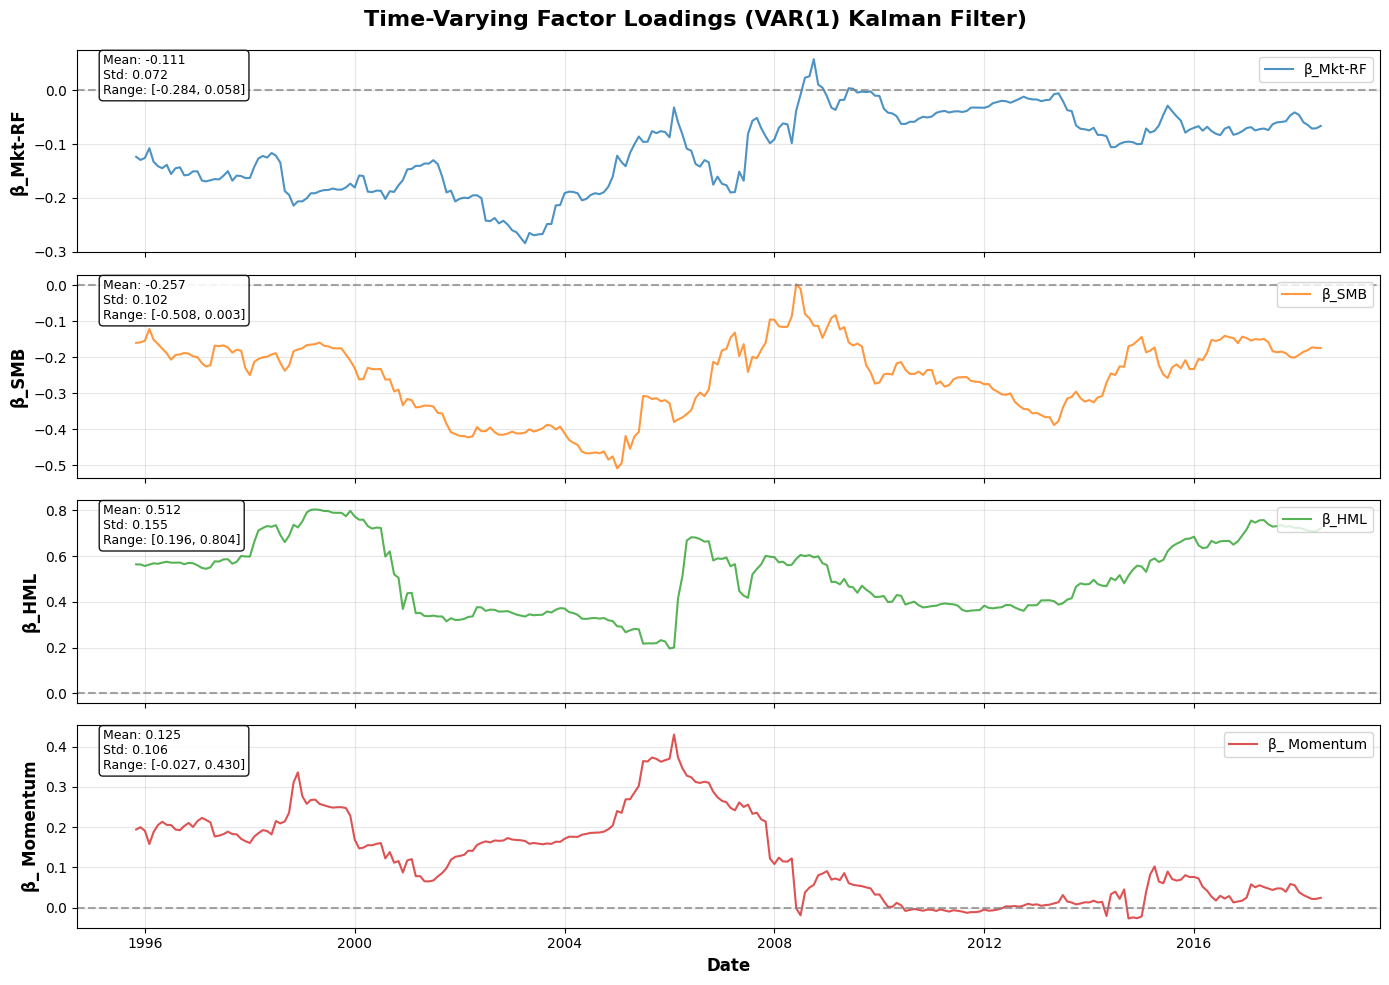


TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)

Summary Statistics:
--------------------------------------------------
       β_Mkt-RF     β_SMB     β_HML  β_ Momentum
count  272.0000  272.0000  272.0000     272.0000
mean    -0.1106   -0.2567    0.5116       0.1246
std      0.0724    0.1022    0.1553       0.1059
min     -0.2842   -0.5081    0.1962      -0.0269
25%     -0.1703   -0.3332    0.3745       0.0272
50%     -0.0974   -0.2343    0.5140       0.1183
75%     -0.0524   -0.1755    0.6431       0.1943
max      0.0579    0.0031    0.8038       0.4304

Factor Loading Correlations:
-----------------------------------
             β_Mkt-RF   β_SMB   β_HML  β_ Momentum
β_Mkt-RF       1.0000  0.3729  0.0046      -0.5573
β_SMB          0.3729  1.0000  0.7008      -0.1711
β_HML          0.0046  0.7008  1.0000       0.0418
β_ Momentum   -0.5573 -0.1711  0.0418       1.0000

Beta Stability Measures:
------------------------------
               Mean  Std Dev  Coeff of Variation     Min  

In [42]:
"""
Kalman Filter for Time-Varying Betas in Fama-French-Carhart (FFC) Model

This implementation uses a VAR(1) state-space model to estimate time-varying
factor loadings (betas) for the four-factor model:
R_t - R_f = β_MKT * (MKT - R_f) + β_SMB * SMB + β_HML * HML + β_MOM * MOM + ε_t

State equation: β_t = A * β_{t-1} + η_t (VAR(1) process)
Observation equation: y_t = X_t * β_t + ε_t
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeVaryingBetaVAR(MLEModel):
    """
    Kalman Filter model for time-varying factor loadings with VAR(1) dynamics
    
    State equation: β_t = A * β_{t-1} + η_t, where η_t ~ N(0, Q)
    Observation equation: y_t = X_t' * β_t + ε_t, where ε_t ~ N(0, σ²)
    """
    
    def __init__(self, endog, exog):
        """
        Initialize the state-space model
        
        Parameters:
        -----------
        endog : array-like
            Endogenous variable (portfolio excess returns)
        exog : array-like
            Exogenous variables (factor returns)
        """
        # Ensure proper shapes
        if endog.ndim == 1:
            endog = endog.reshape(-1, 1)
        if exog.ndim == 1:
            exog = exog.reshape(-1, 1)
            
        self.k_factors = exog.shape[1]
        self.nobs = len(endog)
        self.exog = exog
        
        # Initialize the state space model
        super().__init__(
            endog, 
            k_states=self.k_factors,
            k_posdef=self.k_factors,
            initialization='approximate_diffuse'
        )
        
        # Set up the state space representation
        self._setup_matrices()
    
    def _setup_matrices(self):
        """Setup the state space matrices"""
        # Design matrix Z_t (time-varying): y_t = Z_t * β_t + ε_t
        # Z_t is 1 x k_factors at each time t
        self.ssm['design'] = np.zeros((1, self.k_factors, self.nobs))
        for t in range(self.nobs):
            self.ssm['design', 0, :, t] = self.exog[t, :]
        
        # Transition matrix T (VAR(1)): β_t = T * β_{t-1} + R * η_t
        # Initialize as identity, will be updated in update()
        self.ssm['transition'] = np.eye(self.k_factors)
        
        # Selection matrix R (identity)
        self.ssm['selection'] = np.eye(self.k_factors)
        
        # Initialize covariance matrices (will be updated)
        self.ssm['obs_cov', 0, 0] = 1.0
        self.ssm['state_cov'] = np.eye(self.k_factors) * 0.01
    
    def update(self, params, transformed=True, **kwargs):
        """
        Update the state space representation
        
        Parameters:
        -----------
        params : array-like
            Parameters [log_sigma2, log_q_diag, vec(A)]
        """
        params = super().update(params, transformed, **kwargs)
        
        # Parse parameters
        log_sigma2 = params[0]
        log_q_vars = params[1:1+self.k_factors]
        A_vec = params[1+self.k_factors:]
        
        # Transform parameters
        sigma2 = np.exp(log_sigma2)
        q_vars = np.exp(log_q_vars)
        A = A_vec.reshape((self.k_factors, self.k_factors))
        
        # Update matrices
        self.ssm['obs_cov', 0, 0] = sigma2
        self.ssm['state_cov'] = np.diag(q_vars)
        self.ssm['transition'] = A
    
    @property
    def param_names(self):
        """Parameter names for output"""
        names = ['log_sigma2']
        names.extend([f'log_q_{i+1}' for i in range(self.k_factors)])
        for i in range(self.k_factors):
            for j in range(self.k_factors):
                names.append(f'A_{i+1}_{j+1}')
        return names
    
    @property 
    def start_params(self):
        """Starting values for parameters"""
        # Start with reasonable values
        start_vals = [-3.0]  # log_sigma2
        start_vals.extend([-5.0] * self.k_factors)  # log_q_vars
        start_vals.extend(np.eye(self.k_factors).flatten())  # A matrix (identity)
        return np.array(start_vals)

def clean_data(returns, factors):
    """
    Clean and align data, removing NaN values
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    y_clean : array
        Clean returns array
    X_clean : array  
        Clean factors array
    index_clean : array or Index
        Clean index
    """
    # Convert to pandas for easier handling
    if not isinstance(returns, pd.Series):
        if hasattr(returns, 'index'):
            returns = pd.Series(returns.values.flatten(), index=returns.index)
        else:
            returns = pd.Series(returns.flatten())
    
    if not isinstance(factors, pd.DataFrame):
        if hasattr(factors, 'index'):
            factors = pd.DataFrame(factors, index=factors.index)
        else:
            factors = pd.DataFrame(factors, index=returns.index)
    
    # Align indices
    common_index = returns.index.intersection(factors.index)
    returns = returns.loc[common_index]
    factors = factors.loc[common_index]
    
    # Remove NaN values
    combined = pd.concat([returns, factors], axis=1)
    combined_clean = combined.dropna()
    
    returns_clean = combined_clean.iloc[:, 0]
    factors_clean = combined_clean.iloc[:, 1:]
    
    return returns_clean.values.flatten(), factors_clean.values, returns_clean.index

def estimate_time_varying_betas_rolling(returns, factors, window=60):
    """
    Estimate time-varying betas using rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
    window : int, default 60
        Rolling window size
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    y_clean, X_clean, index_clean = clean_data(returns, factors)
    
    n_obs, n_factors = X_clean.shape
    betas = np.full((n_obs, n_factors), np.nan)
    
    print(f"Estimating rolling betas with {window}-period window...")
    
    for t in range(window, n_obs):
        y_window = y_clean[t-window:t]
        X_window = X_clean[t-window:t]
        
        try:
            # Add constant and run OLS
            X_ols = sm.add_constant(X_window)
            model = sm.OLS(y_window, X_ols).fit()
            betas[t, :] = model.params[1:]  # Exclude constant
        except:
            continue
    
    # Create factor names
    if hasattr(factors, 'columns'):
        factor_names = [f'β_{col}' for col in factors.columns]
    else:
        factor_names = [f'β_{i+1}' for i in range(n_factors)]
    
    betas_df = pd.DataFrame(betas, index=index_clean, columns=factor_names)
    return betas_df.dropna()

def estimate_time_varying_betas(returns, factors, factor_names=None, plot=True, method='kalman'):
    """
    Estimate time-varying betas using Kalman Filter with VAR(1) or rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns (MKT-RF, SMB, HML, MOM)
    factor_names : list, optional
        Names of factors for plotting
    plot : bool, default True
        Whether to create plots
    method : str, default 'kalman'
        Method to use: 'kalman' or 'rolling'
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    model_result : MLEResults or None
        Fitted model results (None for rolling method)
    """
    
    # Clean the data first
    try:
        y_clean, X_clean, index_clean = clean_data(returns, factors)
        print(f"Data cleaned: {len(y_clean)} observations, {X_clean.shape[1]} factors")
    except Exception as e:
        print(f"Error cleaning data: {e}")
        return None, None
    
    # Set factor names
    if factor_names is None:
        if hasattr(factors, 'columns'):
            factor_names = [f'β_{col}' for col in factors.columns]
        else:
            factor_names = [f'β_{i+1}' for i in range(X_clean.shape[1])]
    
    # Choose estimation method
    if method == 'rolling' or len(y_clean) < 100:
        print("Using rolling OLS estimation...")
        betas_df = estimate_time_varying_betas_rolling(
            pd.Series(y_clean, index=index_clean),
            pd.DataFrame(X_clean, index=index_clean)
        )
        betas_df.columns = factor_names
        model_result = None
        
    else:
        print("Attempting Kalman Filter with VAR(1) estimation...")
        try:
            # Fit Kalman filter
            model = TimeVaryingBetaVAR(endog=y_clean, exog=X_clean)
            model_result = model.fit(disp=False, maxiter=1000, method='lbfgs')
            
            # Check convergence
            if model_result.mle_retvals['converged']:
                # Extract smoothed states
                betas_t = model_result.smoothed_state.T
                betas_df = pd.DataFrame(betas_t, index=index_clean, columns=factor_names)
                
                print(f"Kalman Filter converged successfully")
                print(f"Log-likelihood: {model_result.llf:.2f}")
                print(f"AIC: {model_result.aic:.2f}")
            else:
                raise ValueError("Model did not converge")
                
        except Exception as e:
            print(f"Kalman Filter failed: {str(e)}")
            print("Falling back to rolling OLS...")
            betas_df = estimate_time_varying_betas_rolling(
                pd.Series(y_clean, index=index_clean),
                pd.DataFrame(X_clean, index=index_clean)
            )
            betas_df.columns = factor_names
            model_result = None
    
    if plot and betas_df is not None and len(betas_df) > 0:
        plot_time_varying_betas(betas_df)
    
    return betas_df, model_result

def plot_time_varying_betas(betas_df, figsize=(14, 10)):
    """
    Plot time-varying beta estimates
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    figsize : tuple
        Figure size
    """
    betas_df = betas_df.copy()
    betas_df.index = betas_df.index.to_timestamp()
    
    n_factors = len(betas_df.columns)
    fig, axs = plt.subplots(n_factors, 1, figsize=figsize, sharex=True)
    
    if n_factors == 1:
        axs = [axs]
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, col in enumerate(betas_df.columns):
        # Plot time series
        axs[i].plot(betas_df.index, betas_df[col], 
                   label=col, color=colors[i % len(colors)], linewidth=1.5, alpha=0.8)
        
        # Add zero line
        axs[i].axhline(0, linestyle='--', color='gray', alpha=0.7)
        
        # Formatting
        axs[i].set_ylabel(col, fontsize=12, fontweight='bold')
        axs[i].legend(loc='upper right')
        axs[i].grid(True, alpha=0.3)
        
        # Add summary statistics box
        mean_beta = betas_df[col].mean()
        std_beta = betas_df[col].std()
        min_beta = betas_df[col].min()
        max_beta = betas_df[col].max()
        
        stats_text = f'Mean: {mean_beta:.3f}\nStd: {std_beta:.3f}\nRange: [{min_beta:.3f}, {max_beta:.3f}]'
        axs[i].text(0.02, 0.98, stats_text, 
                   transform=axs[i].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
                   fontsize=9)
    
    # Final formatting
    axs[-1].set_xlabel("Date", fontsize=12, fontweight='bold')
    fig.suptitle("Time-Varying Factor Loadings (VAR(1) Kalman Filter)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

def analyze_beta_statistics(betas_df):
    """
    Comprehensive analysis of time-varying betas
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    print("\n" + "="*70)
    print("TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)")
    print("="*70)
    
    # Summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    summary = betas_df.describe()
    print(summary.round(4))
    
    # Correlation matrix
    print("\nFactor Loading Correlations:")
    print("-" * 35)
    corr_matrix = betas_df.corr()
    print(corr_matrix.round(4))
    
    # Beta stability measures
    print("\nBeta Stability Measures:")
    print("-" * 30)
    means = betas_df.mean()
    stds = betas_df.std()
    cv = (stds / means.abs()).round(4)
    
    stability_df = pd.DataFrame({
        'Mean': means.round(4),
        'Std Dev': stds.round(4),
        'Coeff of Variation': cv,
        'Min': betas_df.min().round(4),
        'Max': betas_df.max().round(4)
    })
    print(stability_df)
    
    print(f"\nNote: Coefficient of Variation measures relative volatility of betas")
    print(f"Lower values indicate more stable factor loadings over time")

def compare_estimation_methods(returns, factors):
    """
    Compare Kalman Filter vs Rolling OLS estimates
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    comparison_stats : DataFrame
        Comparison statistics
    """
    print("Comparing Kalman Filter vs Rolling OLS...")
    
    # Get both estimates
    kf_betas, kf_result = estimate_time_varying_betas(returns, factors, method='kalman', plot=False)
    rolling_betas, _ = estimate_time_varying_betas(returns, factors, method='rolling', plot=False)
    
    if kf_betas is None or rolling_betas is None:
        print("Could not compare methods - one or both failed")
        return None
    
    # Align time periods
    common_index = kf_betas.index.intersection(rolling_betas.index)
    kf_aligned = kf_betas.loc[common_index]
    rolling_aligned = rolling_betas.loc[common_index]
    
    # Calculate comparison statistics
    comparison_data = []
    for col in kf_aligned.columns:
        corr = kf_aligned[col].corr(rolling_aligned[col])
        kf_std = kf_aligned[col].std()
        rolling_std = rolling_aligned[col].std()
        mean_diff = (kf_aligned[col] - rolling_aligned[col]).abs().mean()
        
        comparison_data.append({
            'Factor': col,
            'Correlation': corr,
            'KF_Std': kf_std,
            'Rolling_Std': rolling_std,
            'Mean_Abs_Diff': mean_diff
        })
    
    comparison_df = pd.DataFrame(comparison_data).round(4)
    
    print("\nMethod Comparison Results:")
    print("-" * 40)
    print(comparison_df.to_string(index=False))
    
    return comparison_df, kf_betas, rolling_betas

# === Example Usage ===
if __name__ == "__main__":
    print("Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!")
    print("\nUsage Examples:")
    print("1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)")
    print("2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')")
    print("3. Analysis: analyze_beta_statistics(betas_df)")
    print("4. Comparison: compare_estimation_methods(returns, factors)")


# Your data
df_us.index.to_timestamp()
returns_k = df_us['LS-RF']
factors_k = df_us[['Mkt-RF', 'SMB', 'HML', ' Momentum']]
#returns.index = returns.index.to_timestamp()
#factors.index = factors.index.to_timestamp()

# Estimate with VAR(1) Kalman Filter
betas_df, model_result = estimate_time_varying_betas(returns_k, factors_k)

# Analyze results
analyze_beta_statistics(betas_df)

# Compare methods
comparison, kf_betas, rolling_betas = compare_estimation_methods(returns, factors)

Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!

Usage Examples:
1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)
2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')
3. Analysis: analyze_beta_statistics(betas_df)
4. Comparison: compare_estimation_methods(returns, factors)
Data cleaned: 332 observations, 4 factors
Attempting Kalman Filter with VAR(1) estimation...
Kalman Filter failed: 'NoneType' object is not subscriptable
Falling back to rolling OLS...
Estimating rolling betas with 60-period window...


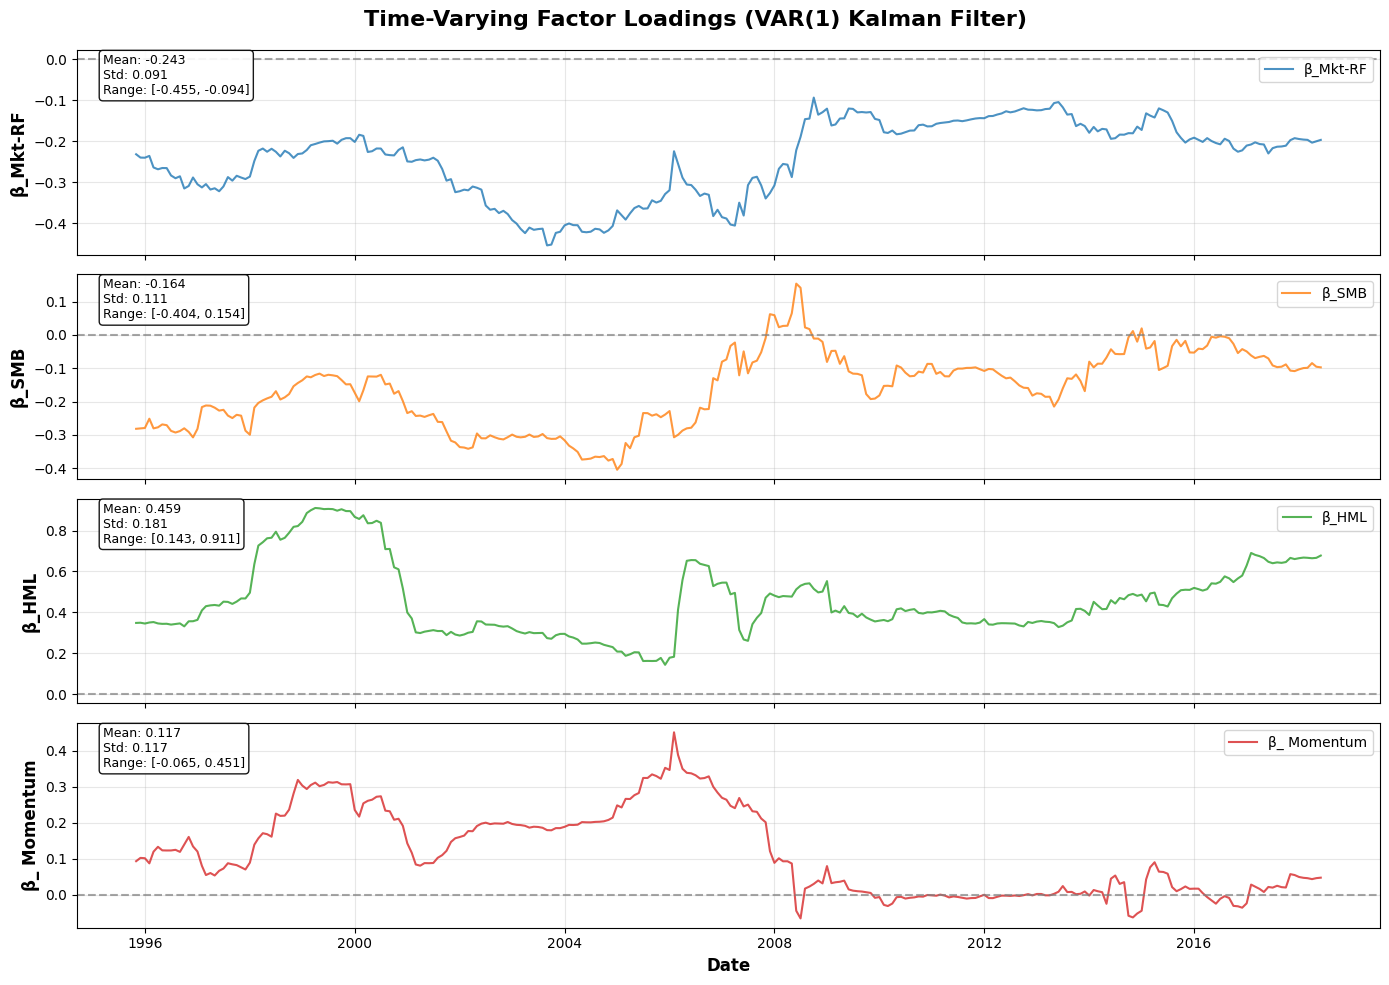


TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)

Summary Statistics:
--------------------------------------------------
       β_Mkt-RF     β_SMB     β_HML  β_ Momentum
count  272.0000  272.0000  272.0000     272.0000
mean    -0.2430   -0.1642    0.4586       0.1166
std      0.0914    0.1109    0.1814       0.1172
min     -0.4547   -0.4044    0.1432      -0.0651
25%     -0.3114   -0.2608    0.3408       0.0084
50%     -0.2216   -0.1449    0.4090       0.0881
75%     -0.1723   -0.0879    0.5428       0.2023
max     -0.0935    0.1541    0.9108       0.4509

Factor Loading Correlations:
-----------------------------------
             β_Mkt-RF   β_SMB   β_HML  β_ Momentum
β_Mkt-RF       1.0000  0.6217  0.3134      -0.6349
β_SMB          0.6217  1.0000  0.4265      -0.4927
β_HML          0.3134  0.4265  1.0000       0.1520
β_ Momentum   -0.6349 -0.4927  0.1520       1.0000

Beta Stability Measures:
------------------------------
               Mean  Std Dev  Coeff of Variation     Min  

In [297]:
"""
Kalman Filter for Time-Varying Betas in Fama-French-Carhart (FFC) Model without HML

This implementation uses a VAR(1) state-space model to estimate time-varying
factor loadings (betas) for the four-factor model:
R_t - R_f = β_MKT * (MKT - R_f) + β_SMB * SMB + β_HML * HML + β_MOM * MOM + ε_t

State equation: β_t = A * β_{t-1} + η_t (VAR(1) process)
Observation equation: y_t = X_t * β_t + ε_t
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeVaryingBetaVAR(MLEModel):
    """
    Kalman Filter model for time-varying factor loadings with VAR(1) dynamics
    
    State equation: β_t = A * β_{t-1} + η_t, where η_t ~ N(0, Q)
    Observation equation: y_t = X_t' * β_t + ε_t, where ε_t ~ N(0, σ²)
    """
    
    def __init__(self, endog, exog):
        """
        Initialize the state-space model
        
        Parameters:
        -----------
        endog : array-like
            Endogenous variable (portfolio excess returns)
        exog : array-like
            Exogenous variables (factor returns)
        """
        # Ensure proper shapes
        if endog.ndim == 1:
            endog = endog.reshape(-1, 1)
        if exog.ndim == 1:
            exog = exog.reshape(-1, 1)
            
        self.k_factors = exog.shape[1]
        self.nobs = len(endog)
        self.exog = exog
        
        # Initialize the state space model
        super().__init__(
            endog, 
            k_states=self.k_factors,
            k_posdef=self.k_factors,
            initialization='approximate_diffuse'
        )
        
        # Set up the state space representation
        self._setup_matrices()
    
    def _setup_matrices(self):
        """Setup the state space matrices"""
        # Design matrix Z_t (time-varying): y_t = Z_t * β_t + ε_t
        # Z_t is 1 x k_factors at each time t
        self.ssm['design'] = np.zeros((1, self.k_factors, self.nobs))
        for t in range(self.nobs):
            self.ssm['design', 0, :, t] = self.exog[t, :]
        
        # Transition matrix T (VAR(1)): β_t = T * β_{t-1} + R * η_t
        # Initialize as identity, will be updated in update()
        self.ssm['transition'] = np.eye(self.k_factors)
        
        # Selection matrix R (identity)
        self.ssm['selection'] = np.eye(self.k_factors)
        
        # Initialize covariance matrices (will be updated)
        self.ssm['obs_cov', 0, 0] = 1.0
        self.ssm['state_cov'] = np.eye(self.k_factors) * 0.01
    
    def update(self, params, transformed=True, **kwargs):
        """
        Update the state space representation
        
        Parameters:
        -----------
        params : array-like
            Parameters [log_sigma2, log_q_diag, vec(A)]
        """
        params = super().update(params, transformed, **kwargs)
        
        # Parse parameters
        log_sigma2 = params[0]
        log_q_vars = params[1:1+self.k_factors]
        A_vec = params[1+self.k_factors:]
        
        # Transform parameters
        sigma2 = np.exp(log_sigma2)
        q_vars = np.exp(log_q_vars)
        A = A_vec.reshape((self.k_factors, self.k_factors))
        
        # Update matrices
        self.ssm['obs_cov', 0, 0] = sigma2
        self.ssm['state_cov'] = np.diag(q_vars)
        self.ssm['transition'] = A
    
    @property
    def param_names(self):
        """Parameter names for output"""
        names = ['log_sigma2']
        names.extend([f'log_q_{i+1}' for i in range(self.k_factors)])
        for i in range(self.k_factors):
            for j in range(self.k_factors):
                names.append(f'A_{i+1}_{j+1}')
        return names
    
    @property 
    def start_params(self):
        """Starting values for parameters"""
        # Start with reasonable values
        start_vals = [-3.0]  # log_sigma2
        start_vals.extend([-5.0] * self.k_factors)  # log_q_vars
        start_vals.extend(np.eye(self.k_factors).flatten())  # A matrix (identity)
        return np.array(start_vals)

def clean_data(returns, factors):
    """
    Clean and align data, removing NaN values
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    y_clean : array
        Clean returns array
    X_clean : array  
        Clean factors array
    index_clean : array or Index
        Clean index
    """
    # Convert to pandas for easier handling
    if not isinstance(returns, pd.Series):
        if hasattr(returns, 'index'):
            returns = pd.Series(returns.values.flatten(), index=returns.index)
        else:
            returns = pd.Series(returns.flatten())
    
    if not isinstance(factors, pd.DataFrame):
        if hasattr(factors, 'index'):
            factors = pd.DataFrame(factors, index=factors.index)
        else:
            factors = pd.DataFrame(factors, index=returns.index)
    
    # Align indices
    common_index = returns.index.intersection(factors.index)
    returns = returns.loc[common_index]
    factors = factors.loc[common_index]
    
    # Remove NaN values
    combined = pd.concat([returns, factors], axis=1)
    combined_clean = combined.dropna()
    
    returns_clean = combined_clean.iloc[:, 0]
    factors_clean = combined_clean.iloc[:, 1:]
    
    return returns_clean.values.flatten(), factors_clean.values, returns_clean.index

def estimate_time_varying_betas_rolling(returns, factors, window=60):
    """
    Estimate time-varying betas using rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
    window : int, default 60
        Rolling window size
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    y_clean, X_clean, index_clean = clean_data(returns, factors)
    
    n_obs, n_factors = X_clean.shape
    betas = np.full((n_obs, n_factors), np.nan)
    
    print(f"Estimating rolling betas with {window}-period window...")
    
    for t in range(window, n_obs):
        y_window = y_clean[t-window:t]
        X_window = X_clean[t-window:t]
        
        try:
            # Add constant and run OLS
            X_ols = sm.add_constant(X_window)
            model = sm.OLS(y_window, X_ols).fit()
            betas[t, :] = model.params[1:]  # Exclude constant
        except:
            continue
    
    # Create factor names
    if hasattr(factors, 'columns'):
        factor_names = [f'β_{col}' for col in factors.columns]
    else:
        factor_names = [f'β_{i+1}' for i in range(n_factors)]
    
    betas_df = pd.DataFrame(betas, index=index_clean, columns=factor_names)
    return betas_df.dropna()

def estimate_time_varying_betas(returns, factors, factor_names=None, plot=True, method='kalman'):
    """
    Estimate time-varying betas using Kalman Filter with VAR(1) or rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns (MKT-RF, SMB, HML, MOM)
    factor_names : list, optional
        Names of factors for plotting
    plot : bool, default True
        Whether to create plots
    method : str, default 'kalman'
        Method to use: 'kalman' or 'rolling'
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    model_result : MLEResults or None
        Fitted model results (None for rolling method)
    """
    
    # Clean the data first
    try:
        y_clean, X_clean, index_clean = clean_data(returns, factors)
        print(f"Data cleaned: {len(y_clean)} observations, {X_clean.shape[1]} factors")
    except Exception as e:
        print(f"Error cleaning data: {e}")
        return None, None
    
    # Set factor names
    if factor_names is None:
        if hasattr(factors, 'columns'):
            factor_names = [f'β_{col}' for col in factors.columns]
        else:
            factor_names = [f'β_{i+1}' for i in range(X_clean.shape[1])]
    
    # Choose estimation method
    if method == 'rolling' or len(y_clean) < 100:
        print("Using rolling OLS estimation...")
        betas_df = estimate_time_varying_betas_rolling(
            pd.Series(y_clean, index=index_clean),
            pd.DataFrame(X_clean, index=index_clean)
        )
        betas_df.columns = factor_names
        model_result = None
        
    else:
        print("Attempting Kalman Filter with VAR(1) estimation...")
        try:
            # Fit Kalman filter
            model = TimeVaryingBetaVAR(endog=y_clean, exog=X_clean)
            model_result = model.fit(disp=False, maxiter=1000, method='lbfgs')
            
            # Check convergence
            if model_result.mle_retvals['converged']:
                # Extract smoothed states
                betas_t = model_result.smoothed_state.T
                betas_df = pd.DataFrame(betas_t, index=index_clean, columns=factor_names)
                
                print(f"Kalman Filter converged successfully")
                print(f"Log-likelihood: {model_result.llf:.2f}")
                print(f"AIC: {model_result.aic:.2f}")
            else:
                raise ValueError("Model did not converge")
                
        except Exception as e:
            print(f"Kalman Filter failed: {str(e)}")
            print("Falling back to rolling OLS...")
            betas_df = estimate_time_varying_betas_rolling(
                pd.Series(y_clean, index=index_clean),
                pd.DataFrame(X_clean, index=index_clean)
            )
            betas_df.columns = factor_names
            model_result = None
    
    if plot and betas_df is not None and len(betas_df) > 0:
        plot_time_varying_betas(betas_df)
    
    return betas_df, model_result

def plot_time_varying_betas(betas_df, figsize=(14, 10)):
    """
    Plot time-varying beta estimates
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    figsize : tuple
        Figure size
    """
    betas_df = betas_df.copy()
    betas_df.index = betas_df.index.to_timestamp()
    
    n_factors = len(betas_df.columns)
    fig, axs = plt.subplots(n_factors, 1, figsize=figsize, sharex=True)
    
    if n_factors == 1:
        axs = [axs]
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, col in enumerate(betas_df.columns):
        # Plot time series
        axs[i].plot(betas_df.index, betas_df[col], 
                   label=col, color=colors[i % len(colors)], linewidth=1.5, alpha=0.8)
        
        # Add zero line
        axs[i].axhline(0, linestyle='--', color='gray', alpha=0.7)
        
        # Formatting
        axs[i].set_ylabel(col, fontsize=12, fontweight='bold')
        axs[i].legend(loc='upper right')
        axs[i].grid(True, alpha=0.3)
        
        # Add summary statistics box
        mean_beta = betas_df[col].mean()
        std_beta = betas_df[col].std()
        min_beta = betas_df[col].min()
        max_beta = betas_df[col].max()
        
        stats_text = f'Mean: {mean_beta:.3f}\nStd: {std_beta:.3f}\nRange: [{min_beta:.3f}, {max_beta:.3f}]'
        axs[i].text(0.02, 0.98, stats_text, 
                   transform=axs[i].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
                   fontsize=9)
    
    # Final formatting
    axs[-1].set_xlabel("Date", fontsize=12, fontweight='bold')
    fig.suptitle("Time-Varying Factor Loadings (VAR(1) Kalman Filter)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

def analyze_beta_statistics(betas_df):
    """
    Comprehensive analysis of time-varying betas
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    print("\n" + "="*70)
    print("TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)")
    print("="*70)
    
    # Summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    summary = betas_df.describe()
    print(summary.round(4))
    
    # Correlation matrix
    print("\nFactor Loading Correlations:")
    print("-" * 35)
    corr_matrix = betas_df.corr()
    print(corr_matrix.round(4))
    
    # Beta stability measures
    print("\nBeta Stability Measures:")
    print("-" * 30)
    means = betas_df.mean()
    stds = betas_df.std()
    cv = (stds / means.abs()).round(4)
    
    stability_df = pd.DataFrame({
        'Mean': means.round(4),
        'Std Dev': stds.round(4),
        'Coeff of Variation': cv,
        'Min': betas_df.min().round(4),
        'Max': betas_df.max().round(4)
    })
    print(stability_df)
    
    print(f"\nNote: Coefficient of Variation measures relative volatility of betas")
    print(f"Lower values indicate more stable factor loadings over time")

def compare_estimation_methods(returns, factors):
    """
    Compare Kalman Filter vs Rolling OLS estimates
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    comparison_stats : DataFrame
        Comparison statistics
    """
    print("Comparing Kalman Filter vs Rolling OLS...")
    
    # Get both estimates
    kf_betas, kf_result = estimate_time_varying_betas(returns, factors, method='kalman', plot=False)
    rolling_betas, _ = estimate_time_varying_betas(returns, factors, method='rolling', plot=False)
    
    if kf_betas is None or rolling_betas is None:
        print("Could not compare methods - one or both failed")
        return None
    
    # Align time periods
    common_index = kf_betas.index.intersection(rolling_betas.index)
    kf_aligned = kf_betas.loc[common_index]
    rolling_aligned = rolling_betas.loc[common_index]
    
    # Calculate comparison statistics
    comparison_data = []
    for col in kf_aligned.columns:
        corr = kf_aligned[col].corr(rolling_aligned[col])
        kf_std = kf_aligned[col].std()
        rolling_std = rolling_aligned[col].std()
        mean_diff = (kf_aligned[col] - rolling_aligned[col]).abs().mean()
        
        comparison_data.append({
            'Factor': col,
            'Correlation': corr,
            'KF_Std': kf_std,
            'Rolling_Std': rolling_std,
            'Mean_Abs_Diff': mean_diff
        })
    
    comparison_df = pd.DataFrame(comparison_data).round(4)
    
    print("\nMethod Comparison Results:")
    print("-" * 40)
    print(comparison_df.to_string(index=False))
    
    return comparison_df, kf_betas, rolling_betas

# === Example Usage ===
if __name__ == "__main__":
    print("Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!")
    print("\nUsage Examples:")
    print("1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)")
    print("2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')")
    print("3. Analysis: analyze_beta_statistics(betas_df)")
    print("4. Comparison: compare_estimation_methods(returns, factors)")


# Your data
df_us.index.to_timestamp()
returns_k = df_us['LS-RF']
factors_k = df_us[['Mkt-RF', 'SMB', 'HML', ' Momentum']]
#returns.index = returns.index.to_timestamp()
#factors.index = factors.index.to_timestamp()

# Estimate with VAR(1) Kalman Filter
betas_df, model_result = estimate_time_varying_betas(returns_k, factors_k)

# Analyze results
analyze_beta_statistics(betas_df)

# Compare methods
comparison, kf_betas, rolling_betas = compare_estimation_methods(returns, factors)

Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!

Usage Examples:
1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)
2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')
3. Analysis: analyze_beta_statistics(betas_df)
4. Comparison: compare_estimation_methods(returns, factors)
Data cleaned: 332 observations, 4 factors
Attempting Kalman Filter with VAR(1) estimation...
Kalman Filter failed: 'NoneType' object is not subscriptable
Falling back to rolling OLS...
Estimating rolling betas with 60-period window...


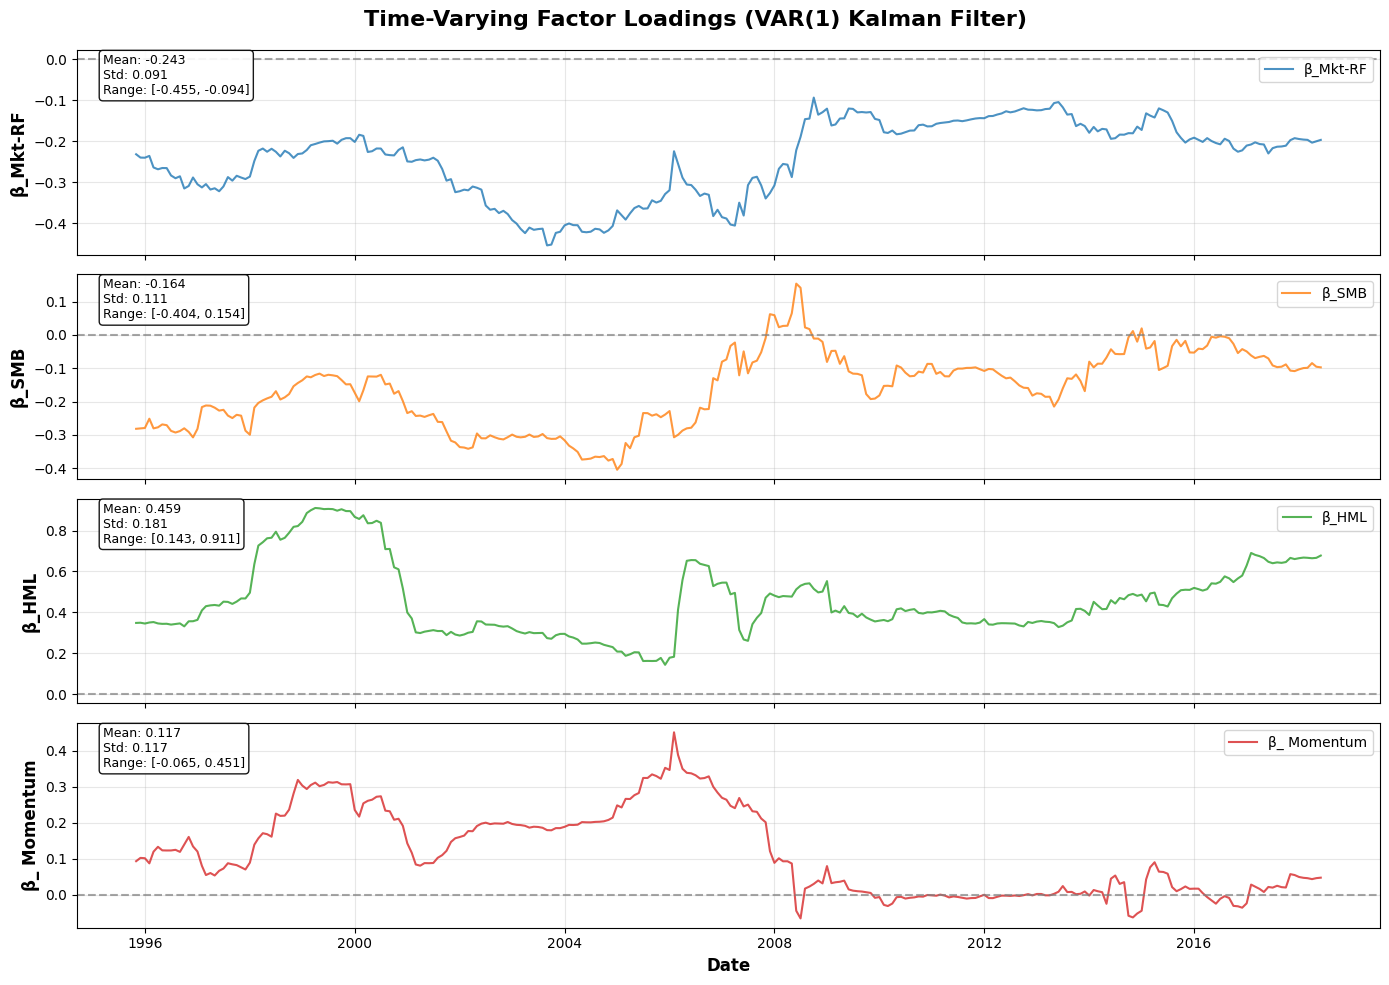


TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)

Summary Statistics:
--------------------------------------------------
       β_Mkt-RF     β_SMB     β_HML  β_ Momentum
count  272.0000  272.0000  272.0000     272.0000
mean    -0.2430   -0.1642    0.4586       0.1166
std      0.0914    0.1109    0.1814       0.1172
min     -0.4547   -0.4044    0.1432      -0.0651
25%     -0.3114   -0.2608    0.3408       0.0084
50%     -0.2216   -0.1449    0.4090       0.0881
75%     -0.1723   -0.0879    0.5428       0.2023
max     -0.0935    0.1541    0.9108       0.4509

Factor Loading Correlations:
-----------------------------------
             β_Mkt-RF   β_SMB   β_HML  β_ Momentum
β_Mkt-RF       1.0000  0.6217  0.3134      -0.6349
β_SMB          0.6217  1.0000  0.4265      -0.4927
β_HML          0.3134  0.4265  1.0000       0.1520
β_ Momentum   -0.6349 -0.4927  0.1520       1.0000

Beta Stability Measures:
------------------------------
               Mean  Std Dev  Coeff of Variation     Min  

'for i in decomposition:\n    # Estimate with VAR(1) Kalman Filter\n    betas_df, model_result = estimate_time_varying_betas(i, factors_k)\n\n    # Analyze results\n    analyze_beta_statistics(betas_df)\n\n    # Compare methods\n    comparison, kf_betas, rolling_betas = compare_estimation_methods(returns, factors)'

In [333]:
#Kalman Filter using VAR(1) model for change in aggregate valuation, income yield and migration
"""
Kalman Filter for Time-Varying Betas in Fama-French-Carhart (FFC) Model without HML

This implementation uses a VAR(1) state-space model to estimate time-varying
factor loadings (betas) for the four-factor model:
R_t - R_f = β_MKT * (MKT - R_f) + β_SMB * SMB + β_HML * HML + β_MOM * MOM + ε_t

State equation: β_t = A * β_{t-1} + η_t (VAR(1) process)
Observation equation: y_t = X_t * β_t + ε_t
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeVaryingBetaVAR(MLEModel):
    """
    Kalman Filter model for time-varying factor loadings with VAR(1) dynamics
    
    State equation: β_t = A * β_{t-1} + η_t, where η_t ~ N(0, Q)
    Observation equation: y_t = X_t' * β_t + ε_t, where ε_t ~ N(0, σ²)
    """
    
    def __init__(self, endog, exog):
        """
        Initialize the state-space model
        
        Parameters:
        -----------
        endog : array-like
            Endogenous variable (portfolio excess returns)
        exog : array-like
            Exogenous variables (factor returns)
        """
        # Ensure proper shapes
        if endog.ndim == 1:
            endog = endog.reshape(-1, 1)
        if exog.ndim == 1:
            exog = exog.reshape(-1, 1)
            
        self.k_factors = exog.shape[1]
        self.nobs = len(endog)
        self.exog = exog
        
        # Initialize the state space model
        super().__init__(
            endog, 
            k_states=self.k_factors,
            k_posdef=self.k_factors,
            initialization='approximate_diffuse'
        )
        
        # Set up the state space representation
        self._setup_matrices()
    
    def _setup_matrices(self):
        """Setup the state space matrices"""
        # Design matrix Z_t (time-varying): y_t = Z_t * β_t + ε_t
        # Z_t is 1 x k_factors at each time t
        self.ssm['design'] = np.zeros((1, self.k_factors, self.nobs))
        for t in range(self.nobs):
            self.ssm['design', 0, :, t] = self.exog[t, :]
        
        # Transition matrix T (VAR(1)): β_t = T * β_{t-1} + R * η_t
        # Initialize as identity, will be updated in update()
        self.ssm['transition'] = np.eye(self.k_factors)
        
        # Selection matrix R (identity)
        self.ssm['selection'] = np.eye(self.k_factors)
        
        # Initialize covariance matrices (will be updated)
        self.ssm['obs_cov', 0, 0] = 1.0
        self.ssm['state_cov'] = np.eye(self.k_factors) * 0.01
    
    def update(self, params, transformed=True, **kwargs):
        """
        Update the state space representation
        
        Parameters:
        -----------
        params : array-like
            Parameters [log_sigma2, log_q_diag, vec(A)]
        """
        params = super().update(params, transformed, **kwargs)
        
        # Parse parameters
        log_sigma2 = params[0]
        log_q_vars = params[1:1+self.k_factors]
        A_vec = params[1+self.k_factors:]
        
        # Transform parameters
        sigma2 = np.exp(log_sigma2)
        q_vars = np.exp(log_q_vars)
        A = A_vec.reshape((self.k_factors, self.k_factors))
        
        # Update matrices
        self.ssm['obs_cov', 0, 0] = sigma2
        self.ssm['state_cov'] = np.diag(q_vars)
        self.ssm['transition'] = A
    
    @property
    def param_names(self):
        """Parameter names for output"""
        names = ['log_sigma2']
        names.extend([f'log_q_{i+1}' for i in range(self.k_factors)])
        for i in range(self.k_factors):
            for j in range(self.k_factors):
                names.append(f'A_{i+1}_{j+1}')
        return names
    
    @property 
    def start_params(self):
        """Starting values for parameters"""
        # Start with reasonable values
        start_vals = [-3.0]  # log_sigma2
        start_vals.extend([-5.0] * self.k_factors)  # log_q_vars
        start_vals.extend(np.eye(self.k_factors).flatten())  # A matrix (identity)
        return np.array(start_vals)

def clean_data(returns, factors):
    """
    Clean and align data, removing NaN values
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    y_clean : array
        Clean returns array
    X_clean : array  
        Clean factors array
    index_clean : array or Index
        Clean index
    """
    # Convert to pandas for easier handling
    if not isinstance(returns, pd.Series):
        if hasattr(returns, 'index'):
            returns = pd.Series(returns.values.flatten(), index=returns.index)
        else:
            returns = pd.Series(returns.flatten())
    
    if not isinstance(factors, pd.DataFrame):
        if hasattr(factors, 'index'):
            factors = pd.DataFrame(factors, index=factors.index)
        else:
            factors = pd.DataFrame(factors, index=returns.index)
    
    # Align indices
    common_index = returns.index.intersection(factors.index)
    returns = returns.loc[common_index]
    factors = factors.loc[common_index]
    
    # Remove NaN values
    combined = pd.concat([returns, factors], axis=1)
    combined_clean = combined.dropna()
    
    returns_clean = combined_clean.iloc[:, 0]
    factors_clean = combined_clean.iloc[:, 1:]
    
    return returns_clean.values.flatten(), factors_clean.values, returns_clean.index

def estimate_time_varying_betas_rolling(returns, factors, window=60):
    """
    Estimate time-varying betas using rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
    window : int, default 60
        Rolling window size
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    y_clean, X_clean, index_clean = clean_data(returns, factors)
    
    n_obs, n_factors = X_clean.shape
    betas = np.full((n_obs, n_factors), np.nan)
    
    print(f"Estimating rolling betas with {window}-period window...")
    
    for t in range(window, n_obs):
        y_window = y_clean[t-window:t]
        X_window = X_clean[t-window:t]
        
        try:
            # Add constant and run OLS
            X_ols = sm.add_constant(X_window)
            model = sm.OLS(y_window, X_ols).fit()
            betas[t, :] = model.params[1:]  # Exclude constant
        except:
            continue
    
    # Create factor names
    if hasattr(factors, 'columns'):
        factor_names = [f'β_{col}' for col in factors.columns]
    else:
        factor_names = [f'β_{i+1}' for i in range(n_factors)]
    
    betas_df = pd.DataFrame(betas, index=index_clean, columns=factor_names)
    return betas_df.dropna()

def estimate_time_varying_betas(returns, factors, factor_names=None, plot=True, method='kalman'):
    """
    Estimate time-varying betas using Kalman Filter with VAR(1) or rolling OLS
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns (MKT-RF, SMB, HML, MOM)
    factor_names : list, optional
        Names of factors for plotting
    plot : bool, default True
        Whether to create plots
    method : str, default 'kalman'
        Method to use: 'kalman' or 'rolling'
        
    Returns:
    --------
    betas_df : DataFrame
        Time-varying beta estimates
    model_result : MLEResults or None
        Fitted model results (None for rolling method)
    """
    
    # Clean the data first
    try:
        y_clean, X_clean, index_clean = clean_data(returns, factors)
        print(f"Data cleaned: {len(y_clean)} observations, {X_clean.shape[1]} factors")
    except Exception as e:
        print(f"Error cleaning data: {e}")
        return None, None
    
    # Set factor names
    if factor_names is None:
        if hasattr(factors, 'columns'):
            factor_names = [f'β_{col}' for col in factors.columns]
        else:
            factor_names = [f'β_{i+1}' for i in range(X_clean.shape[1])]
    
    # Choose estimation method
    if method == 'rolling' or len(y_clean) < 100:
        print("Using rolling OLS estimation...")
        betas_df = estimate_time_varying_betas_rolling(
            pd.Series(y_clean, index=index_clean),
            pd.DataFrame(X_clean, index=index_clean)
        )
        betas_df.columns = factor_names
        model_result = None
        
    else:
        print("Attempting Kalman Filter with VAR(1) estimation...")
        try:
            # Fit Kalman filter
            model = TimeVaryingBetaVAR(endog=y_clean, exog=X_clean)
            model_result = model.fit(disp=False, maxiter=1000, method='lbfgs')
            
            # Check convergence
            if model_result.mle_retvals['converged']:
                # Extract smoothed states
                betas_t = model_result.smoothed_state.T
                betas_df = pd.DataFrame(betas_t, index=index_clean, columns=factor_names)
                
                print(f"Kalman Filter converged successfully")
                print(f"Log-likelihood: {model_result.llf:.2f}")
                print(f"AIC: {model_result.aic:.2f}")
            else:
                raise ValueError("Model did not converge")
                
        except Exception as e:
            print(f"Kalman Filter failed: {str(e)}")
            print("Falling back to rolling OLS...")
            betas_df = estimate_time_varying_betas_rolling(
                pd.Series(y_clean, index=index_clean),
                pd.DataFrame(X_clean, index=index_clean)
            )
            betas_df.columns = factor_names
            model_result = None
    
    if plot and betas_df is not None and len(betas_df) > 0:
        plot_time_varying_betas(betas_df)
    
    return betas_df, model_result

def plot_time_varying_betas(betas_df, figsize=(14, 10)):
    """
    Plot time-varying beta estimates
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    figsize : tuple
        Figure size
    """
    betas_df = betas_df.copy()
    betas_df.index = betas_df.index.to_timestamp()
    
    n_factors = len(betas_df.columns)
    fig, axs = plt.subplots(n_factors, 1, figsize=figsize, sharex=True)
    
    if n_factors == 1:
        axs = [axs]
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, col in enumerate(betas_df.columns):
        # Plot time series
        axs[i].plot(betas_df.index, betas_df[col], 
                   label=col, color=colors[i % len(colors)], linewidth=1.5, alpha=0.8)
        
        # Add zero line
        axs[i].axhline(0, linestyle='--', color='gray', alpha=0.7)
        
        # Formatting
        axs[i].set_ylabel(col, fontsize=12, fontweight='bold')
        axs[i].legend(loc='upper right')
        axs[i].grid(True, alpha=0.3)
        
        # Add summary statistics box
        mean_beta = betas_df[col].mean()
        std_beta = betas_df[col].std()
        min_beta = betas_df[col].min()
        max_beta = betas_df[col].max()
        
        stats_text = f'Mean: {mean_beta:.3f}\nStd: {std_beta:.3f}\nRange: [{min_beta:.3f}, {max_beta:.3f}]'
        axs[i].text(0.02, 0.98, stats_text, 
                   transform=axs[i].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
                   fontsize=9)
    
    # Final formatting
    axs[-1].set_xlabel("Date", fontsize=12, fontweight='bold')
    fig.suptitle("Time-Varying Factor Loadings (VAR(1) Kalman Filter)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

def analyze_beta_statistics(betas_df):
    """
    Comprehensive analysis of time-varying betas
    
    Parameters:
    -----------
    betas_df : DataFrame
        Time-varying beta estimates
    """
    print("\n" + "="*70)
    print("TIME-VARYING BETA ANALYSIS (VAR(1) KALMAN FILTER)")
    print("="*70)
    
    # Summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    summary = betas_df.describe()
    print(summary.round(4))
    
    # Correlation matrix
    print("\nFactor Loading Correlations:")
    print("-" * 35)
    corr_matrix = betas_df.corr()
    print(corr_matrix.round(4))
    
    # Beta stability measures
    print("\nBeta Stability Measures:")
    print("-" * 30)
    means = betas_df.mean()
    stds = betas_df.std()
    cv = (stds / means.abs()).round(4)
    
    stability_df = pd.DataFrame({
        'Mean': means.round(4),
        'Std Dev': stds.round(4),
        'Coeff of Variation': cv,
        'Min': betas_df.min().round(4),
        'Max': betas_df.max().round(4)
    })
    print(stability_df)
    
    print(f"\nNote: Coefficient of Variation measures relative volatility of betas")
    print(f"Lower values indicate more stable factor loadings over time")

def compare_estimation_methods(returns, factors):
    """
    Compare Kalman Filter vs Rolling OLS estimates
    
    Parameters:
    -----------
    returns : array-like or Series
        Portfolio excess returns
    factors : array-like or DataFrame
        Factor returns
        
    Returns:
    --------
    comparison_stats : DataFrame
        Comparison statistics
    """
    print("Comparing Kalman Filter vs Rolling OLS...")
    
    # Get both estimates
    kf_betas, kf_result = estimate_time_varying_betas(returns, factors, method='kalman', plot=False)
    rolling_betas, _ = estimate_time_varying_betas(returns, factors, method='rolling', plot=False)
    
    if kf_betas is None or rolling_betas is None:
        print("Could not compare methods - one or both failed")
        return None
    
    # Align time periods
    common_index = kf_betas.index.intersection(rolling_betas.index)
    kf_aligned = kf_betas.loc[common_index]
    rolling_aligned = rolling_betas.loc[common_index]
    
    # Calculate comparison statistics
    comparison_data = []
    for col in kf_aligned.columns:
        corr = kf_aligned[col].corr(rolling_aligned[col])
        kf_std = kf_aligned[col].std()
        rolling_std = rolling_aligned[col].std()
        mean_diff = (kf_aligned[col] - rolling_aligned[col]).abs().mean()
        
        comparison_data.append({
            'Factor': col,
            'Correlation': corr,
            'KF_Std': kf_std,
            'Rolling_Std': rolling_std,
            'Mean_Abs_Diff': mean_diff
        })
    
    comparison_df = pd.DataFrame(comparison_data).round(4)
    
    print("\nMethod Comparison Results:")
    print("-" * 40)
    print(comparison_df.to_string(index=False))
    
    return comparison_df, kf_betas, rolling_betas

# === Example Usage ===
if __name__ == "__main__":
    print("Time-Varying Beta Estimation with VAR(1) Kalman Filter Ready!")
    print("\nUsage Examples:")
    print("1. Kalman Filter: betas_df, result = estimate_time_varying_betas(returns, factors)")
    print("2. Rolling OLS: betas_df, _ = estimate_time_varying_betas(returns, factors, method='rolling')")
    print("3. Analysis: analyze_beta_statistics(betas_df)")
    print("4. Comparison: compare_estimation_methods(returns, factors)")


# Your data
#df_us.index = df_us.index.to_timestamp()
returns_k = df_us['LS-RF']
factors_k = df_us[['Mkt-RF', 'SMB', 'HML', ' Momentum']]
#returns.index = returns.index.to_timestamp()
#factors.index = factors.index.to_timestamp()
#decomposition = [df_us['Change in aggregate valuation'], df_us['Income Yield'], df_us['Migration']]

betas_df, model_result = estimate_time_varying_betas(returns_k, factors_k)
analyze_beta_statistics(betas_df)


"""for i in decomposition:
    # Estimate with VAR(1) Kalman Filter
    betas_df, model_result = estimate_time_varying_betas(i, factors_k)

    # Analyze results
    analyze_beta_statistics(betas_df)

    # Compare methods
    comparison, kf_betas, rolling_betas = compare_estimation_methods(returns, factors)"""